# CNN for acoustic scene classfication: my life environment

Date: March 5, 2019

Neural network: input MFSCs to CNN

## Preparing data set for CNN

In [2]:
DATASET_FOLDER = '../dataset/data_environment'

%run ../oscilloscope/script/dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate(flatten=False)
shape = ds.shape
class_labels = ds.class_labels

((980, 64, 40, 1), (420, 64, 40, 1))

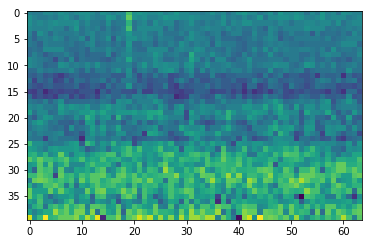

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(np.rot90(train_data[0].reshape(ds.shape)))
train_data.shape, test_data.shape

### CNN model

In [4]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 38, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 19, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 17, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 8, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 6, 32)         4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

In [5]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

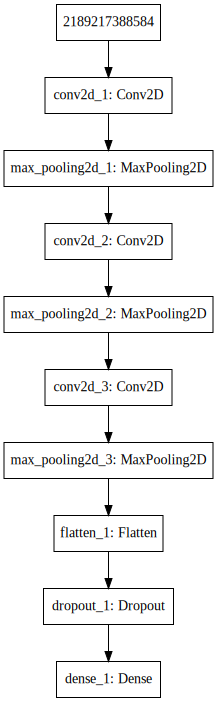

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [7]:
EPOCHS = 50
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 980 samples, validate on 420 samples
Epoch 1/50
980/980 [==============================] - 36s 37ms/step - loss: 1.8272 - acc: 0.2561 - val_loss: 1.5543 - val_acc: 0.4738
Epoch 2/50
980/980 [==============================] - 34s 34ms/step - loss: 1.5688 - acc: 0.3939 - val_loss: 1.3095 - val_acc: 0.5595
Epoch 3/50
980/980 [==============================] - 33s 34ms/step - loss: 1.4007 - acc: 0.4806 - val_loss: 1.1975 - val_acc: 0.6095
Epoch 4/50
980/980 [==============================] - 33s 34ms/step - loss: 1.2758 - acc: 0.5224 - val_loss: 1.1242 - val_acc: 0.6190
Epoch 5/50
980/980 [==============================] - 33s 34ms/step - loss: 1.1698 - acc: 0.6020 - val_loss: 1.0239 - val_acc: 0.6381
Epoch 6/50
980/980 [==============================] - 32s 33ms/step - loss: 1.1157 - acc: 0.6051 - val_loss: 0.9126 - val_acc: 0.6857
Epoch 7/50
980/980 [==============================] - 31s 31ms/step - loss: 0.9853 - acc: 0.6561 - val_loss: 0.9990 - val_acc: 0.6595
Epoch 8/50
980/9

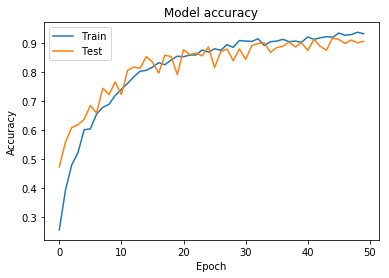

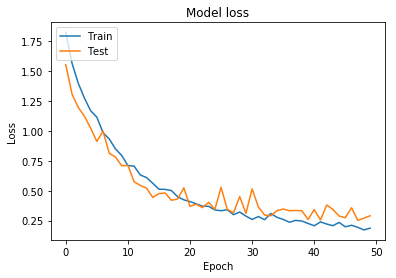

In [8]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [9]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_environment{}.h5'.format(dt)
model.save(filename)

## Load the model

In [10]:
del model
model = models.load_model(filename)

## Confirmation

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [13]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [14]:
class_labels

['train', 'station', 'fastfood', 'escalator', 'mall', 'street', 'port']

In [15]:
(activations[-1][:10]*100).astype(int)

array([[ 0, 99,  0,  0,  0,  0,  0],
       [99,  0,  0,  0,  0,  0,  0],
       [83,  0,  1,  0, 13,  1,  0],
       [ 0,  0, 93,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0, 99],
       [ 3,  0,  0, 41,  0, 55,  0],
       [ 0,  0, 99,  0,  0,  0,  0],
       [ 0,  0, 99,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 99],
       [ 0,  1, 98,  0,  0,  0,  0]])

In [16]:
test_labels[:10].astype(int)

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0]])

In [17]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'train'

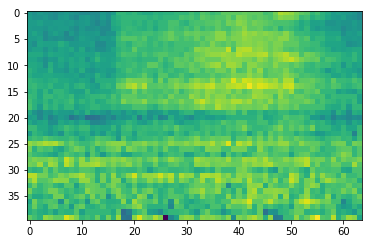

In [18]:
image_number = 2

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

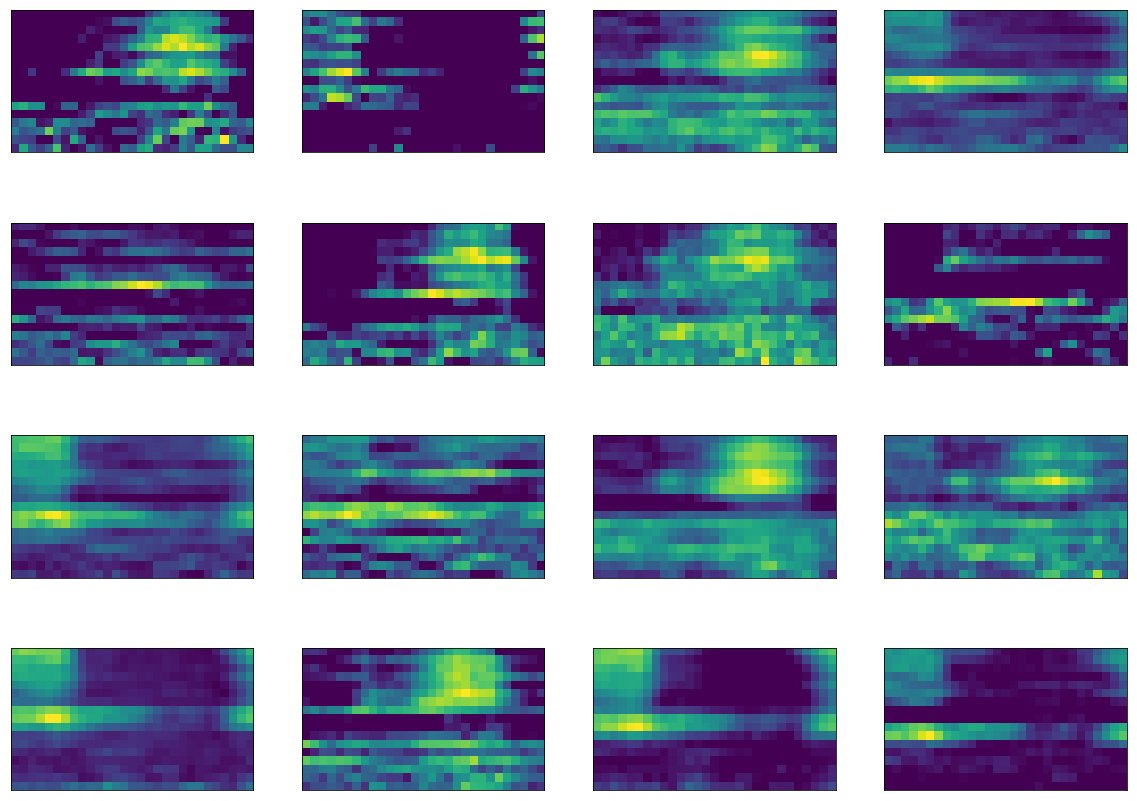

In [19]:
plot_layer(activations, image_number, 2)

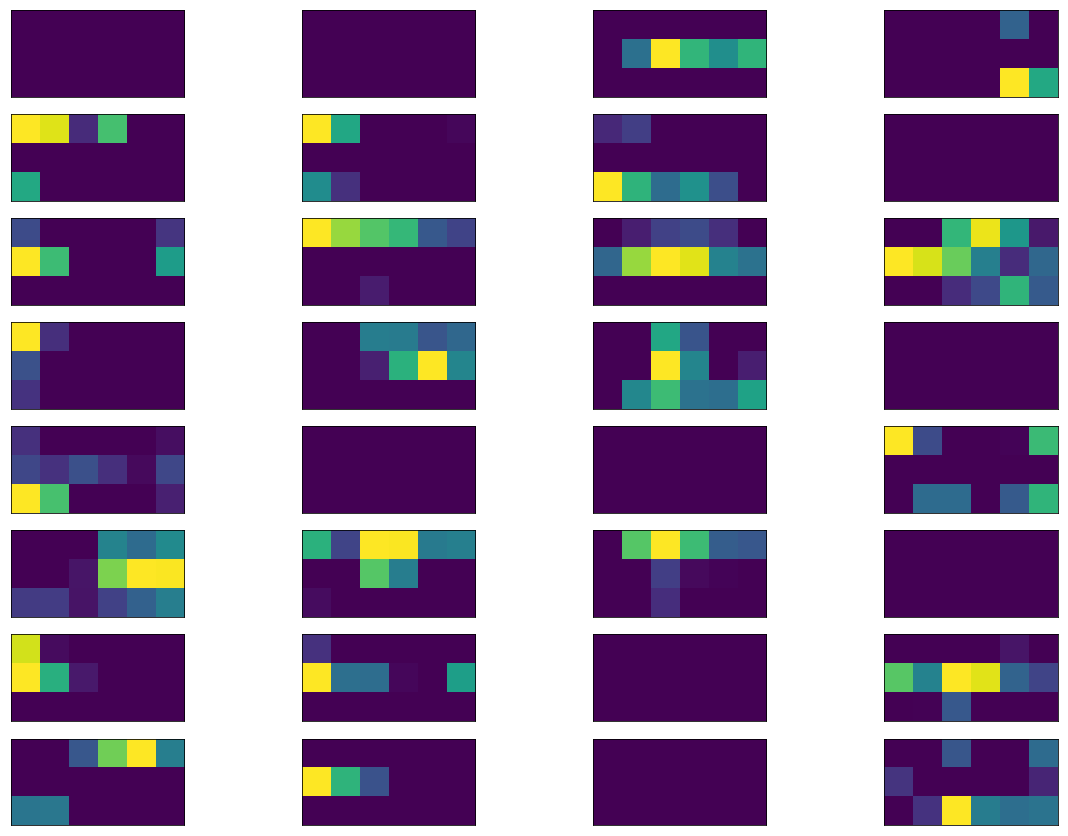

In [20]:
plot_layer(activations, image_number, 5)